# Loading Real Data as an input for a model

In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time import time


In [3]:
# To open images and operate with them we will use PIL
# Among other libraries to load paths
import os
from PIL import Image
from IPython.display import display
import warnings

# Ignoring some warnings
warnings.filterwarnings('ignore')


------------

## Exploring the Imageset

Loading the dataset

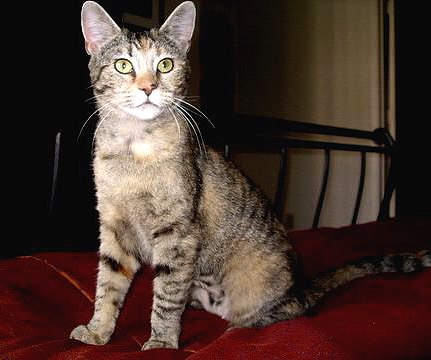

In [4]:
# We will load the Cats & Dogs dataset
with Image.open('../Course Resources/Data/CATS_DOGS/test/CAT/10000.jpg') as im:
    display(im)

In [5]:
# Loading path
path = '../Course Resources/Data/CATS_DOGS/'
img_names = []

# Getting all filenames
for folders, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folders + '/' + img)

# Check how many images we have
len(img_names)

24994

In [6]:
# Getting insights of the images
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

# Check how many accepted and rejected
print(f'Accepted images: {len(img_sizes)}')
print(f'Rejected images: {len(rejected)}')

Accepted images: 24994
Rejected images: 0


In [7]:
# Converting to a dataframe
df = pd.DataFrame(img_sizes, columns=['width', 'height'])

df.head()

,width,height
0,431,360
1,500,375
2,500,471
3,500,375
4,320,240


In [8]:
# Let's check data from the width
df['width'].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: width, dtype: float64

In [9]:
# Let's check data from the height
df['height'].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: height, dtype: float64

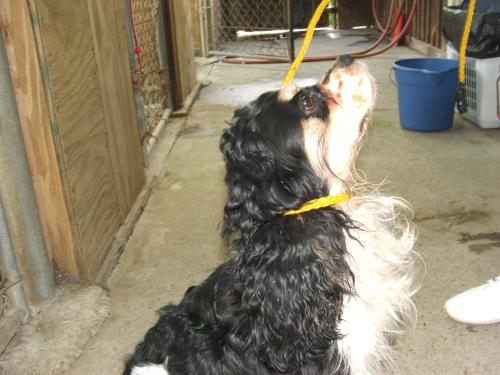

In [10]:
# Checking a dog image
dog = Image.open('../Course Resources/Data/CATS_DOGS/test/DOG/10017.jpg')
display(dog)

In [10]:
# Shape
dog.size

In [11]:
# Let's see the value of a pixe
dog.getpixel((0, 0))

(163, 132, 104)

We can se that the image is loaded as an uint8 image, that means that can have values from 0 to 255 with no negatives

In [12]:
# Permorm a transformation
# With compose we can perform differents transforms at once
transform = transforms.Compose([
    transforms.ToTensor()
])

# Let's transform and see the property's of the image
im = transform(dog)
print(type(im))
print(im.shape)

<class 'torch.Tensor'>
torch.Size([3, 375, 500])


A better way to work with images is using the format [width, height, channels], but PIL loads putting the
number of channels as the first element, we can change it and will do in the following cell

(-0.5, 499.5, 374.5, -0.5)

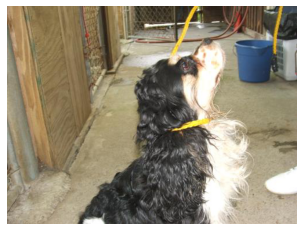

In [13]:
# Original [3, 375, 500]
# First, convert to a numpy array
# Then we transpose as the way we want
numpy_img = np.transpose(im.numpy(), (1, 2, 0))

# If no transpose has been done, we cannot display the image with matplotlib
plt.imshow(numpy_img)
plt.axis('off')

In [14]:
# Taking a look at a pixel
im[:, 0, 0]

tensor([0.6392, 0.5176, 0.4078])

Numpy automatically normalized our data!

In [15]:
# Checking normalization
np.array([90, 95, 98]) / 255

array([0.35294118, 0.37254902, 0.38431373])

---------------

After those test we will re-define our transform method to be better!

torch.Size([3, 250, 250])


(-0.5, 249.5, 249.5, -0.5)

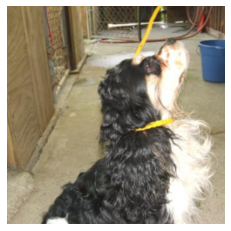

In [20]:
 # With compose we can perform differents transforms at once
transform = transforms.Compose([
    transforms.Resize(250),  # Makes all images the same shape
    transforms.CenterCrop(250), # Center and crop the image
    transforms.ToTensor()
])

# Let's transform and see the property's of the image
im = transform(dog)
print(im.shape)

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.axis('off')

More transforms!

torch.Size([3, 375, 500])


(-0.5, 499.5, 374.5, -0.5)

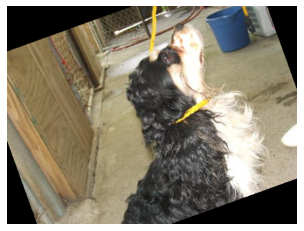

In [27]:
 # With compose we can perform differents transforms at once
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.2), # probability of 0.2 to be flipped
    transforms.RandomRotation(30), # Rotates the grades given in all directions
    transforms.ToTensor()
])

# Let's transform and see the property's of the image
im = transform(dog)
print(im.shape)

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.axis('off')

torch.Size([3, 250, 250])


(-0.5, 249.5, 249.5, -0.5)

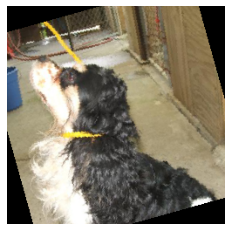

In [28]:
 # With compose we can perform differents transforms at once
transform = transforms.Compose([
    transforms.Resize(250),  # Makes all images the same shape
    transforms.CenterCrop(250), # Center and crop the image
    transforms.RandomHorizontalFlip(p=0.2), # probability of 0.2 to be flipped
    transforms.RandomRotation(30), # Rotates the grades given in all directions
    transforms.ToTensor()
])

# Let's transform and see the property's of the image
im = transform(dog)
print(im.shape)

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 375, 500])


(-0.5, 499.5, 374.5, -0.5)

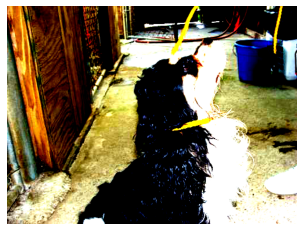

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Those particulary values are known to be better for training.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From 0 - 1 values
])

im = transform(dog)
print(im.shape)

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.axis('off')

torch.Size([3, 375, 500])


(-0.5, 499.5, 374.5, -0.5)

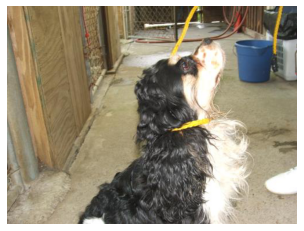

In [31]:
inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)
print(im_inv.shape)

plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')